<a href="https://colab.research.google.com/github/ewerton-andrade/DataScienceEvolution/blob/main/Pytorch_Transfer_Learning_For_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dados do aluno**
# - **Aluno**: Ewerton Lima de Andrade
# - **email**: etonandrade@gmail.com
# - **acesse esse notebook colab no github**:
# - **Assunto**: "I2A2 - ABDI -Challenge 5"

# **Objetivo**: Realizar o CRISP-DM (business understanding, data understanding e data preparation) para construir um modelo que classifique imagens de cães e gatos.


# **1- Primeira Fase: Business Understanding (Compreensão do negócio)** **bold text**

# A classificação de imagens é uma das soluções que a I.A oferece. Para essa tarefa uma das melhores soluções é o uso de Redes Neurais profundas (RNA), em especial as Redes Neurais Convolucionais (CNN). Por essa razão vou utilizar uma CNN juntamente com a técnica do transfer learning utilizando pytorch.

<h1>Versão do Python</h1>

In [2]:
!python --version

Python 3.10.12


<h1>Versão de Pacotes Python instalados via Pip</h1>

In [3]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bidict                           0.23.1

<h1>Importando as bibliotecas necessárias</h1>

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion() #redraw figures when a element changes

# **2- Segunda Fase: Data Understanding (Compreensão dos dados)**



## Os dados consistem em treino e validação e são compostos por centenas de milhares de imagens de gatos e cães.

# **3- Terceira Fase: Data Processing (Processamento dos dados)**

<h1><strong>Carregando os dados</strong></h1>

<h2>Existem algumas formas de carregar imagens para utilizar no google colab:

1- Carregar os dados da máquina local utilizando a função de upload de arquivos;

2- Acessar os dados por meio do google Drive;
</h2>

<h2><strong>Acessando os dados por meio do google drive</strong></h2>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h2><strong>Acessando os dados a partir da máquina local (Opcional)</strong></h2>

In [6]:
# from google.colab import files

# # Prompt the user to upload files
# uploaded = files.upload()

# # Print the uploaded filenames
# for filename in uploaded.keys():
#     print(f'Uploaded file: {filename}')

<h2>Informe o caminho do diretório em que os dados estão.</h2>

In [7]:
data_dir = '/content/drive/MyDrive/I2A2/Desafio5I2A2/dataset'

<h1>Utilizando o transforms do Pytorch (torchvision) eu consigo aplicar algumas técnicas de pré processamento de imagens antes do treino.</h1>

<h1><strong> Para os Dados de treino eu realizo duas técnicas: </strong></h1>

<ol>
<li><p>- Data augmentation (Aumento de dados);</p></li>

<li><p>- Normalização para o treinamento.</p></li>
</ol>

<h1><strong> Para os Dados de teste eu realizo apenas uma técnica: </strong></h1>

<ol>
<li><p>Normalização</p></li>
</ol>

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<h1>Visualizar imagens</h1>

<h2>Abaixo é uma função para visualizar a imagem e o rótulo respectivo dentro do conjunto de dados:</h2>

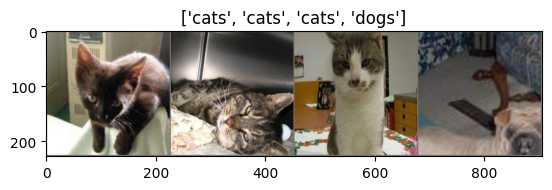

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# **4 e 5- Quarta e Quinta Fase: Data Modeling e Validation (Modelagem e Validação)**

<h2><strong>Treinando o modelo</strong></h2>

<h2>Esta é uma função geral para treinamento de modelo, utilizando um exemplo de como incrementear o aprendizado e salvar o melhor modelo. O parâmetro 'scheduler' é um objeto do tipo LR scheduler do
´torch.optim.lr_scheduler´.
</h2>

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

<h1><strong>Visualizando os modelos</strong></h1>

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

<h1><strong>Ajuste do ConvNet</strong></h1>

<h2>Carregar um modelo pré-treinado e reiniciar camada final totalmente conectada.</h2>

In [12]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s] 


<h1>Treinamento e avaliação</h1>

Pode levar entre 15-25 minutos em uma CPU. Por meio de uma GPU leva menos de um minuto.

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4999 Acc: 0.8000
val Loss: 0.1071 Acc: 0.9636

Epoch 1/24
----------
train Loss: 0.3175 Acc: 0.8642
val Loss: 0.1054 Acc: 0.9591

Epoch 2/24
----------
train Loss: 0.2414 Acc: 0.8939
val Loss: 0.1164 Acc: 0.9591

Epoch 3/24
----------
train Loss: 0.2218 Acc: 0.9068
val Loss: 0.0778 Acc: 0.9721

Epoch 4/24
----------
train Loss: 0.1986 Acc: 0.9120
val Loss: 0.1015 Acc: 0.9661

Epoch 5/24
----------
train Loss: 0.2006 Acc: 0.9122
val Loss: 0.0819 Acc: 0.9726

Epoch 6/24
----------
train Loss: 0.1803 Acc: 0.9235
val Loss: 0.0672 Acc: 0.9796

Epoch 7/24
----------
train Loss: 0.1468 Acc: 0.9383
val Loss: 0.0685 Acc: 0.9800

Epoch 8/24
----------
train Loss: 0.1230 Acc: 0.9471
val Loss: 0.0655 Acc: 0.9805

Epoch 9/24
----------
train Loss: 0.1241 Acc: 0.9459
val Loss: 0.0629 Acc: 0.9830

Epoch 10/24
----------
train Loss: 0.1204 Acc: 0.9479
val Loss: 0.0668 Acc: 0.9796

Epoch 11/24
----------
train Loss: 0.1126 Acc: 0.9514
val Loss: 0.0557 Acc: 0.9820

Ep

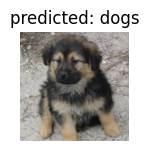

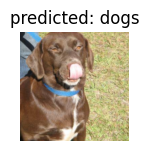

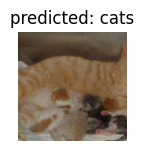

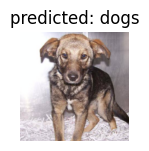

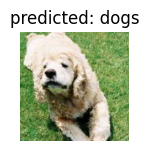

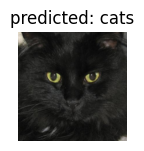

In [14]:
visualize_model(model_ft)

# ConvNet como extrator de recursos fixos

## Aqui, preciso congelar toda a rede, exceto a camada final. É necessário definir `requires_grad = False` para congelar os parâmetros para que o gradientes não são calculados em `backward()`.


In [15]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# *Treinamento* e validação


In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4971 Acc: 0.8046
val Loss: 0.0701 Acc: 0.9761

Epoch 1/24
----------
train Loss: 0.5025 Acc: 0.8091
val Loss: 0.2576 Acc: 0.9057

Epoch 2/24
----------
train Loss: 0.4647 Acc: 0.8211
val Loss: 0.0721 Acc: 0.9746

Epoch 3/24
----------
train Loss: 0.4651 Acc: 0.8194
val Loss: 0.0852 Acc: 0.9736

Epoch 4/24
----------
train Loss: 0.4917 Acc: 0.8102
val Loss: 0.0739 Acc: 0.9796

Epoch 5/24
----------
train Loss: 0.4582 Acc: 0.8226
val Loss: 0.1140 Acc: 0.9541

Epoch 6/24
----------
train Loss: 0.4998 Acc: 0.8134
val Loss: 0.0808 Acc: 0.9681

Epoch 7/24
----------
train Loss: 0.3565 Acc: 0.8491
val Loss: 0.1172 Acc: 0.9541

Epoch 8/24
----------
train Loss: 0.3439 Acc: 0.8487
val Loss: 0.0826 Acc: 0.9711

Epoch 9/24
----------
train Loss: 0.3551 Acc: 0.8401
val Loss: 0.0836 Acc: 0.9756

Epoch 10/24
----------
train Loss: 0.3447 Acc: 0.8425
val Loss: 0.0809 Acc: 0.9766

Epoch 11/24
----------
train Loss: 0.3436 Acc: 0.8473
val Loss: 0.0823 Acc: 0.9721

Ep

# Abaixo por meio da função criada anteriomente é possível verificar a classificação do modelo junto com a respectiva imagem classificada.

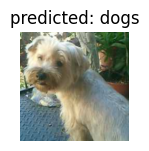

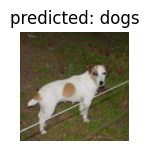

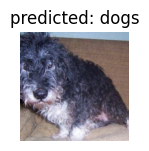

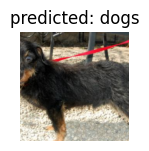

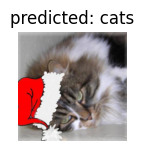

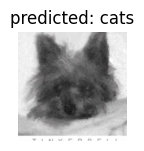

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# Inferência em imagens personalizadas

## É possível utilizar o modelo treinado para fazer previsões em imagens personalizadas e visualizar os rótulos de classe previstos junto com as imagens.

In [18]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

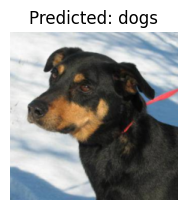

In [19]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/I2A2/Desafio5I2A2/dataset/val/dogs/dog.5000.jpg'
)

plt.ioff()
plt.show()

## Abaixo eu classifico a imagem do meu próprio pet.

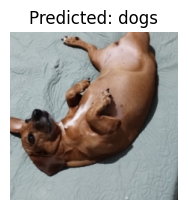

In [24]:
visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/I2A2/Desafio5I2A2/dataset/val/dogs/xixa1.jpeg'
)

plt.ioff()
plt.show()

# Conclusão: Utilizar a técnica do Transfer Learning fez com que a rede conseguisse generalizar bem a predição para as classes "cão" e "gato" outros testes foram feitos sem utilizar essa técnica e foram bem inferiores em performance.